In [ ]:
!pip install kaggle

!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset
License(s): CC0-1.0
 99% 102M/103M [00:01<00:00, 87.1MB/s] 
100% 103M/103M [00:01<00:00, 70.7MB/s]


In [ ]:
# Basic
import os
from os import listdir
import numpy as np
import pandas as pd
import zipfile

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Specify the path to the zip file containing the dataset and the extraction location
train_file_path = "/content/car-vs-bike-classification-dataset.zip"  # Replace with the actual path to the dataset zip file
files = "/content"  # Replace with the path to the folder where files will be extracted

# Open the zip file and extract all its contents
with zipfile.ZipFile(train_file_path, 'r') as zip_file:
    zip_file.extractall(files)  # Extract files to the specified folder

In [ ]:
main_dir = "/content/Car-Bike-Dataset"
folders = os.listdir(main_dir)
files_paths = []
labels = []
for folder in folders:
    fold_path = os.path.join(main_dir, folder)
    files = os.listdir(fold_path)
    for file in files:
        file_path = os.path.join(fold_path, file)
        files_paths.append(file_path)
        labels.append(folder)
df = pd.DataFrame({"File Path": files_paths, "Labels": labels})
df.head(10)

,File Path,Labels
0,/content/Car-Bike-Dataset/Bike/Bike (459).jpeg,Bike
1,/content/Car-Bike-Dataset/Bike/Bike (1091).jpeg,Bike
2,/content/Car-Bike-Dataset/Bike/Bike (1164).jpeg,Bike
3,/content/Car-Bike-Dataset/Bike/Bike (1340).jpeg,Bike
4,/content/Car-Bike-Dataset/Bike/Bike (164).jpg,Bike
5,/content/Car-Bike-Dataset/Bike/Bike (1166).jpeg,Bike
6,/content/Car-Bike-Dataset/Bike/images (22).jpeg,Bike
7,/content/Car-Bike-Dataset/Bike/Bike (1004).jpeg,Bike
8,/content/Car-Bike-Dataset/Bike/Bike (774).jpeg,Bike
9,/content/Car-Bike-Dataset/Bike/Bike (19).jpg,Bike


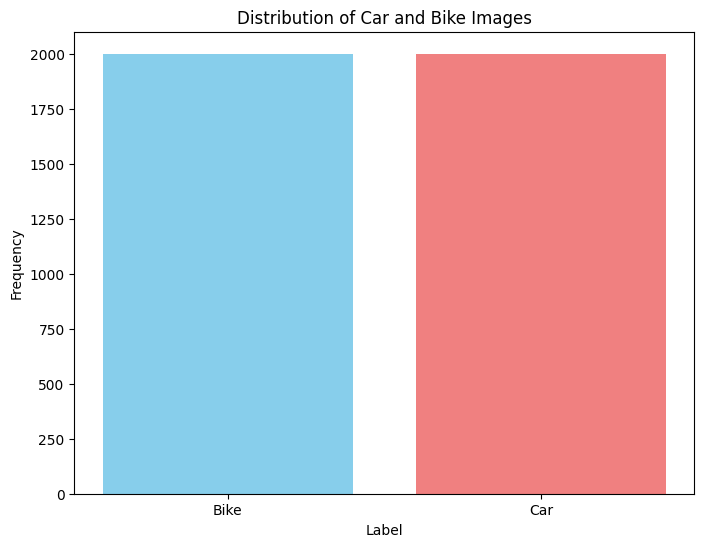

In [ ]:
# @title Distribution of Car and Bike Images

import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named 'df'
label_counts = df['Labels'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'lightcoral'])
plt.title('Distribution of Car and Bike Images')
plt.xlabel('Label')
plt.ylabel('Frequency')
_ = plt.xticks(rotation=0)  # Ensure labels are horizontal

[2664 3240 1453  388 3707 2435 2390  752 1976 2674 1913 3080 3011  727
  512 2505]


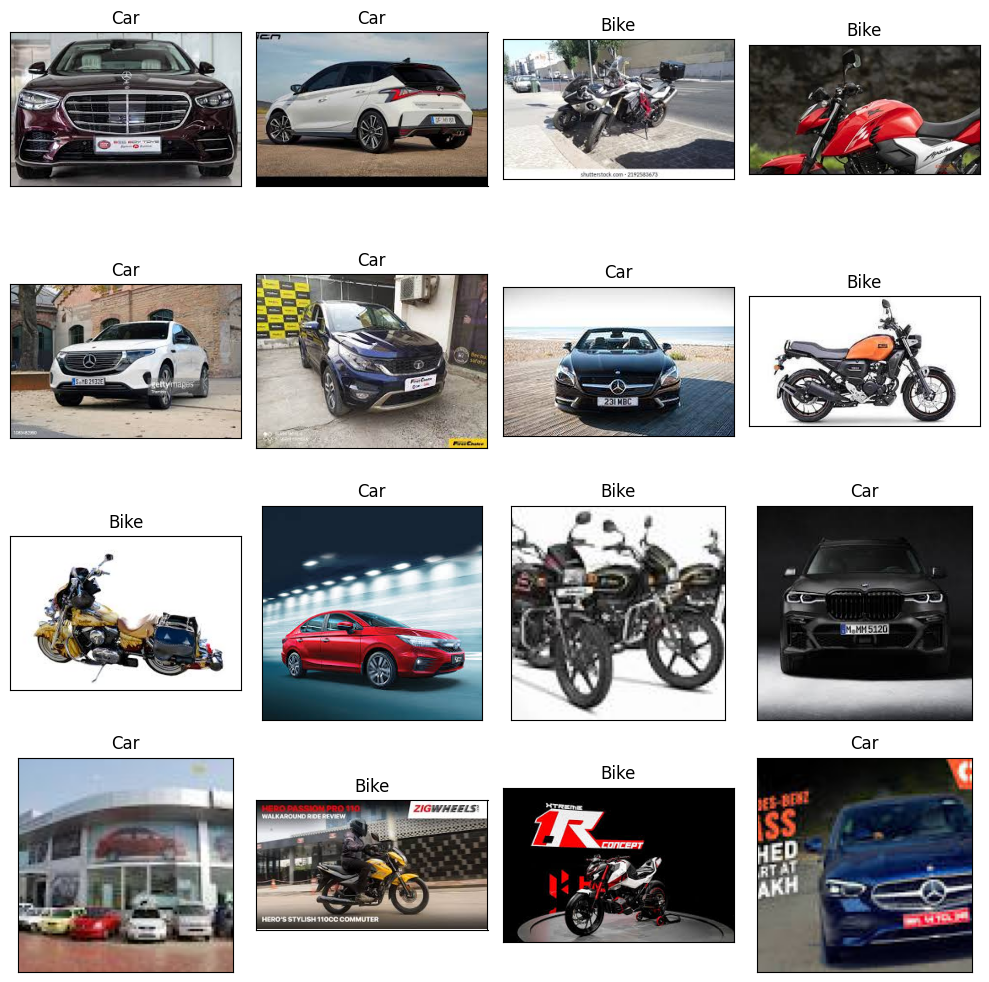

In [ ]:
random_index = np.random.randint(0, len(df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File Path"][random_index[i]])) # Use "File Path" instead of "Filepath"
    ax.set_title(df.Labels[random_index[i]]) # Use "Labels" instead of "Label"
plt.tight_layout()
plt.show()

In [ ]:

# Split data into training (70%) and test (30%) sets
X_train, X_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)



# Print the shapes of the resulting datasets
print('The shape of train data', X_train.shape)
print('The shape of test data', X_test.shape)


The shape of train data (3200, 2)
The shape of test data (800, 2)


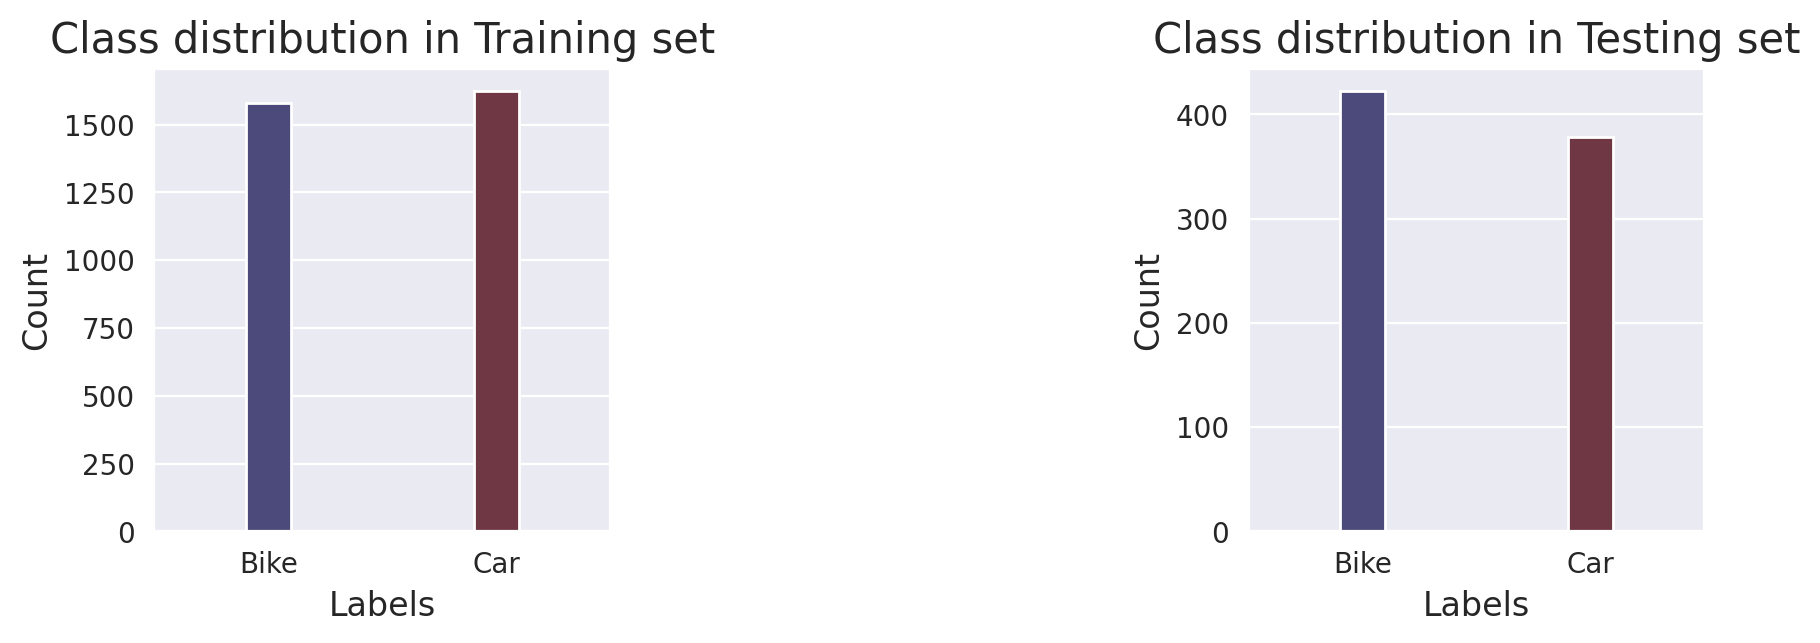

In [ ]:
labels = ['Bike','Car']  # Assuming 'Bike' and 'Car' are your actual labels

label1, count1 = np.unique(X_train['Labels'], return_counts=True) # Access 'Labels' column using bracket notation
label3, count3 = np.unique(X_test['Labels'], return_counts=True) # Access 'Labels' column using bracket notation

uni1 = pd.DataFrame(data=count1, index=labels, columns=['Count1'])
uni3 = pd.DataFrame(data=count3, index=labels, columns=['Count3'])

plt.figure(figsize=(10,3),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

In [ ]:
image_size = (224, 224)# Image size
image_channel = 3 # Number of color channels
batch_size = 32  # Batch size for training the model



In [ ]:
# Create ImageDataGenerator for training with image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalize image pixels to the range 0-1
                                    rotation_range=40,  # Random rotation of images
                                    horizontal_flip=True,  # Flip images horizontally
                                    zoom_range=0.2,  # Random zoom on images
                                    shear_range=0.2,  # Random shear transformation on images
                                    fill_mode='nearest',  # Method to fill empty pixels after transformations
                                    width_shift_range=0.2,  # Random horizontal shift of images
                                    validation_split=0.2,
                                    height_shift_range=0.2)  # Random vertical shift of images

# Create ImageDataGenerator for testing
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize image pixels to the range 0-1 for testing


In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=X_train,  # Use the training split
                                                    directory=main_dir,  # Directory containing images
                                                    x_col='File Path',  # Column containing image filenames
                                                    y_col='Labels',  # Column containing image labels
                                                    batch_size=batch_size,  # Batch size for training
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    subset='training',
                                                    target_size=image_size)  # Resize images to target size

val_generator = train_datagen.flow_from_dataframe(dataframe=X_train,  # Use the validation split
                                                 directory=main_dir,  # Directory containing images
                                                 x_col='File Path',  # Column containing image filenames
                                                 y_col='Labels',  # Column containing image labels
                                                 batch_size=batch_size,  # Batch size for validation
                                                 class_mode='binary',
                                                  shuffle=True,
                                                  subset='validation',
                                                 target_size=image_size)  # Resize images
test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=main_dir,
    x_col='File Path',
    y_col='Labels',  # Ensure 'label' column has numerical data (0/1)
    shuffle=False,
    batch_size=batch_size,
    target_size=image_size,
    class_mode='binary'  # Ensure this is set for binary classification
)

Found 2560 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Load the VGG19 model with pre-trained weights
pretrained_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers to retain the features learned
for layer in pretrained_model.layers:
    layer.trainable = False

# Add new custom layers on top of the VGG19 backbone
x = layers.GlobalAveragePooling2D()(pretrained_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)  # Binary classification output

# Define the final model
model = Model(inputs=pretrained_model.input, outputs=x)

# Compile the model with the Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Correct loss for binary classification
    metrics=['accuracy']
)

# Add callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("vgg19_cats_dogs_model.keras", save_best_only=True)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,155,969 (76.89 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 587ms/step - accuracy: 0.5465 - loss: 3.9293 - val_accuracy: 0.8703 - val_loss: 3.2988
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 565ms/step - accuracy: 0.7297 - loss: 3.1591 - val_accuracy: 0.8750 - val_loss: 2.6747
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 536ms/step - accuracy: 0.7942 - loss: 2.5721 - val_accuracy: 0.9016 - val_loss: 2.1794
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 564ms/step - accuracy: 0.8394 - loss: 2.1005 - val_accuracy: 0.9062 - val_loss: 1.7930
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 524ms/step - accuracy: 0.8722 - loss: 1.7322 - val_accuracy: 0.9031 - val_loss: 1.4978
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 544ms/step - accuracy: 0.8797 - loss: 1.4493 - val_accuracy: 0.9094 - val_loss: 1.2648
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 574ms/step - accuracy: 0.8963 - loss: 1.2212 - val_accuracy: 0.9219 - val_loss: 1.0592
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 540ms/step - accuracy: 0.8933 - loss: 1.0449 - val_accu

In [ ]:
# Retrieve final training accuracy and loss
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
#Validation set Accuracy
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Evaluate the model on the testing set using the test_generator
test_loss, test_acc = model.evaluate(test_generator)  # Use test_generator instead of test_images
print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

Final Training Accuracy: 0.9195
Final Training Loss: 0.4182
Final Validation Accuracy: 0.9422
Final Validation Loss: 0.3892
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9504 - loss: 0.3459
Testing Accuracy: 0.9538
Testing Loss: 0.3403


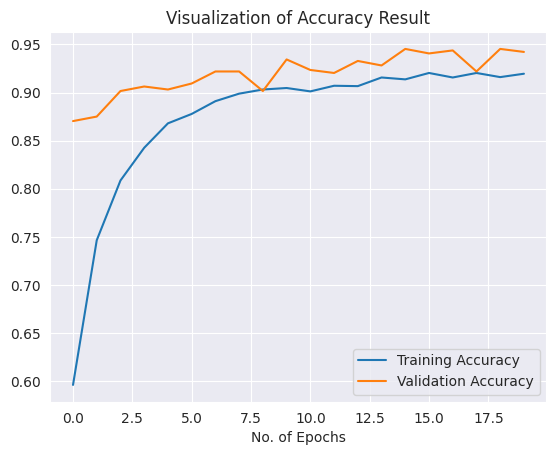

In [ ]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Visualization of Accuracy Result')
plt.xlabel('No. of Epochs')
plt.legend();
plt.show()



In [ ]:
# Assuming you have 'test_generator' defined from a previous cell
pred = model.predict(test_generator)

# Get the true labels from the test generator
true_labels = test_generator.classes

# Get the predicted labels (0 or 1)
pred_labels = (pred > 0.5).astype(int)  # Assuming 0.5 as the threshold for binary classification

# Map the predicted labels to class names ('Cat' or 'Dog')
labels = (train_generator.class_indices)  # Get class indices from train_generator
labels = dict((v,k) for k,v in labels.items())  # Invert the dictionary
pred_classes = [labels[k[0]] for k in pred_labels]
# Display the result
print(f'The first 10 predictions: {pred_classes[:10]}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step
The first 10 predictions: ['Bike', 'Car', 'Bike', 'Car', 'Car', 'Bike', 'Bike', 'Bike', 'Bike', 'Bike']


In [ ]:
y_test = list(X_test['Labels']) # Changed 'label' to 'Labels'
report = classification_report(y_test, pred_classes, output_dict=True) # pred_classes maps prediction to class names
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Bike,0.930649,0.985782,0.957422,422.00000
Car,0.983003,0.917989,0.949384,378.00000
accuracy,0.953750,0.953750,0.953750,0.95375
macro avg,0.956826,0.951886,0.953403,800.00000
weighted avg,0.955386,0.953750,0.953624,800.00000


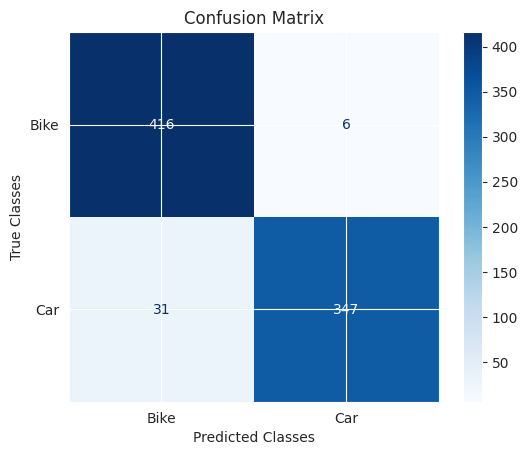

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels from the test generator (assuming you have 'test_generator')
y_test = test_generator.classes

# Map the true labels to class names (Bike or Car)
y_test_labels = [labels[label] for label in y_test] # 'labels' dict is defined in a previous cell

# Convert true labels to numerical labels (0 for 'Bike', 1 for 'Car')
y_test_numeric = [0 if label == 'Bike' else 1 for label in y_test_labels]

# Convert prediction probabilities to binary predictions (0 or 1) using a threshold
pred_binary = (pred > 0.5).astype(int)

# Now, create the confusion matrix
cm = confusion_matrix(y_test_numeric, pred_binary)

# Define your class names (matching the numerical labels)
class_names = ['Bike', 'Car']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Change the color to blue
disp.plot(cmap='Blues')

plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')

plt.show()